<a href="https://colab.research.google.com/github/guillaumetougas/sbl_hyperspectral_ai/blob/main/02_scripts/sbl_hyperspec_1D_CNN_3species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1D-CNN model from hyperspectral data


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torchvision as tv
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchaudio as ta
!pip install rasterio
import rasterio as rio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.7 MB/s eta 0:00:00


###Load preprocessed HS data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
#Load HS data with geopandas
smoothed_data=gpd.read_file("/content/drive/MyDrive/2024-Tougas-PhD/Data_SBL_HS_AI/sbl_smoothed_spectra.gpkg")

#isolate spectral data and prepare with rasterio
spectral_data_labeled = smoothed_data.drop(columns=['geometry']).values
print(type(spectral_data_labeled))
print(spectral_data_labeled.shape)
#print(np.shape(spectral_data_labeled))
#print(spectral_data_labeled[:5])

#filter out unwanted species (keep 3 most important)
# Get column index for 'Label'
label_col_idx = smoothed_data.columns.get_loc('Label')  # Find the column index for 'Label'

# Get unique labels and their counts using numpy
unique_labels, label_counts = np.unique(spectral_data_labeled[:, label_col_idx], return_counts=True)

# Sort labels by counts and get the top 3
sorted_indices = np.argsort(label_counts)[::-1]  # Sort in descending order
top_3_species = unique_labels[sorted_indices[:3]]

# Filter spectral_data_labeled based on top_3_species
filtered_indices = np.isin(spectral_data_labeled[:, label_col_idx], top_3_species)
filtered_data = spectral_data_labeled[filtered_indices]

spectral_data = filtered_data[:, 1:243]
print(spectral_data[:,241])
print(len(spectral_data))

labels = filtered_data[:,label_col_idx]
print(labels.shape)

<class 'numpy.ndarray'>
(21696, 246)
[0.06830659106593368 0.05044518727648489 0.00028019072714709 ...
 0.054798048697016474 0.0 0.0]
14008
(14008,)


### Create the 1D-CNN model

In [5]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Example hyperspectral data (N samples, C spectral bands)
# Replace this with your actual data
N, C = len(spectral_data), spectral_data.shape[1]
# Example: 21696 pixels, 242 bands
#X = spectral_data
#Y = labels

# Normalization (recommended for pretrained generic models like 1D CNN)
spectral_data = (spectral_data - np.min(spectral_data)) / (np.max(spectral_data) - np.min(spectral_data))

# Ensure spectral_data has a numeric dtype before converting to tensor
spectral_data = spectral_data.astype(np.float32)  # or np.float64

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spectral_data, labels, test_size=0.2, random_state=42)

# 1. Create train/val indices instead of directly splitting
dataset_size = len(spectral_data)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))  # 20% for validation
print(split)
np.random.shuffle(indices)  # Shuffle indices randomly
train_indices, val_indices = indices[split:], indices[:split]

# 2. Separate data using the indices
X_train, X_val = spectral_data[train_indices], spectral_data[val_indices]
y_train, y_val = labels[train_indices], labels[val_indices]

# 3. Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# 4. Create PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32)
y_train, y_val = torch.tensor(y_train_encoded, dtype=torch.long), torch.tensor(y_val_encoded, dtype=torch.long)

14008
2801


In [6]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)  # If using CUDA
torch.cuda.manual_seed_all(42)  # If using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define a 1D CNN for hyperspectral data classification
class HyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(HyperspectralCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        fc1_input_size = 128 * input_channels #output size of conv2 x number of bands
        self.fc1 = nn.Linear(fc1_input_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        # x = self.pool(x)

        # Check if x has 3 dimensions before accessing x.size(2)
        #if x.dim() == 3:
        fc1_input_size = x.size(1) * x.size(2)
        #else:
            # If x has only 2 dimensions, calculate fc1_input_size accordingly
        #    fc1_input_size = x.size(1)

        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Adjust fc1 input size to match the actual flattened size
        self.fc1 = nn.Linear(fc1_input_size, 256)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Set up focal loss function for class imbalance

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

###Model parameters and optimizer and loss function set up





In [8]:
# Model parameters
input_channels = C
num_classes = len(torch.unique(y_train))  # Number of unique labels
# Reshape for 1D CNN - Assuming spectral bands are in rows
# Transpose to have samples in rows and spectral bands in columns
X_train = X_train.T
X_val = X_val.T

# Reshape X_train before the loop
X_train_reshaped = X_train.T[:, :, None]  # add extra dimension to have a 3D tensor

# Create train_dataset and train_loader outside the loop
train_dataset = torch.utils.data.TensorDataset(X_train_reshaped, y_train)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = HyperspectralCNN(input_channels, num_classes)
criterion = FocalLoss(gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)


###Train the model

In [26]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)  # If using CUDA
torch.cuda.manual_seed_all(42)  # If using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Training loop
num_epochs = 30  # You can adjust this
for epoch in range(num_epochs):
  for batch_idx, (data, target) in enumerate(train_loader):
    # Forward pass
    outputs = model(data)
    loss = criterion(outputs, target)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print loss every 100 iterations
    if (batch_idx + 1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{batch_idx+1}], Loss: {loss.item():.4f}')

Epoch [1/10], Iteration [100], Loss: 0.2970
Epoch [1/10], Iteration [200], Loss: 0.3302
Epoch [1/10], Iteration [300], Loss: 0.3437
Epoch [2/10], Iteration [100], Loss: 0.3578
Epoch [2/10], Iteration [200], Loss: 0.3027
Epoch [2/10], Iteration [300], Loss: 0.5265
Epoch [3/10], Iteration [100], Loss: 0.3575
Epoch [3/10], Iteration [200], Loss: 0.2817
Epoch [3/10], Iteration [300], Loss: 0.3497
Epoch [4/10], Iteration [100], Loss: 0.2859
Epoch [4/10], Iteration [200], Loss: 0.3782
Epoch [4/10], Iteration [300], Loss: 0.3337
Epoch [5/10], Iteration [100], Loss: 0.3867
Epoch [5/10], Iteration [200], Loss: 0.4437
Epoch [5/10], Iteration [300], Loss: 0.3593
Epoch [6/10], Iteration [100], Loss: 0.2382
Epoch [6/10], Iteration [200], Loss: 0.3929
Epoch [6/10], Iteration [300], Loss: 0.4220
Epoch [7/10], Iteration [100], Loss: 0.3041
Epoch [7/10], Iteration [200], Loss: 0.2257
Epoch [7/10], Iteration [300], Loss: 0.3468
Epoch [8/10], Iteration [100], Loss: 0.3565
Epoch [8/10], Iteration [200], L

###Evaluate the model

In [27]:
# Evaluate the model on a test dataset
model.eval()
with torch.no_grad():
   # Reshape the validation data to add an extra dimension for sequence length
    X_val_reshaped = X_val.T[:, :, None]

    # Create a DataLoader for the validation set
    val_dataset = torch.utils.data.TensorDataset(X_val_reshaped, y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for evaluation

    total_correct = 0
    total_samples = 0

    for data, target in val_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)  # Get predicted class labels
        total_correct += (predicted == target).sum().item()
        total_samples += target.size(0)

    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.5598


###Visualize model performance

In [11]:
!pip install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

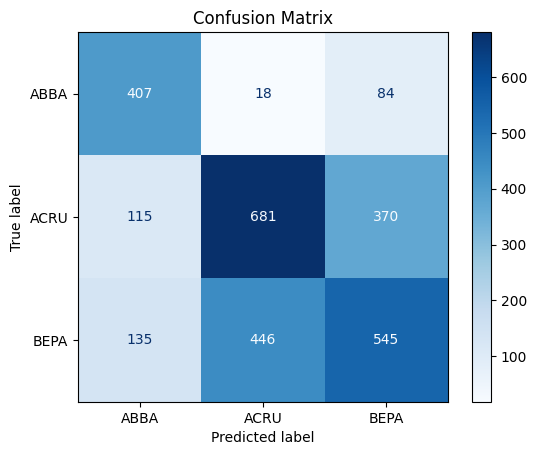

[407 681 545]


In [28]:
# Get predictions for the entire validation set
with torch.no_grad():
    X_val_reshaped = X_val.T[:, :, None]  # Reshape validation data
    outputs = model(X_val_reshaped)
    _, predicted = torch.max(outputs, 1)  # Get predicted class labels

# Calculate confusion matrix
cm = confusion_matrix(y_val.cpu().numpy(), predicted.cpu().numpy(),labels=np.arange(len(label_encoder.classes_)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(np.diagonal(cm)) #Only ABBA, ACRU and THOC present TP

In [29]:
# Assuming y_true and y_pred are your true and predicted labels
with torch.no_grad():
    X_val_reshaped = X_val.T[:, :, None]  # Reshape validation data
    outputs = model(X_val_reshaped)
    _, predicted = torch.max(outputs, 1)  # Get predicted class labels


# Note: y_val is already on the CPU since it was used in the validation loop
f1 = f1_score(y_val, predicted.cpu(), average='weighted')  # Use 'weighted' for multi-class
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.5962


In [30]:
from sklearn.metrics import classification_report

report = classification_report(
        y_val,
        predicted.cpu(),
        target_names=label_encoder.classes_,
        labels=np.arange(len(label_encoder.classes_))  # All classes in the encoder
  )
print(report)

file_path = '/content/drive/MyDrive/2024-Tougas-PhD/Data_SBL_HS_AI/classification_reports/20241212_classification_report_200_epochs.txt'

#with open(file_path, 'w') as f:
#    report = classification_report(
#        y_val,
#        predicted.cpu(),
#        target_names=label_encoder.classes_,
#        labels=np.arange(len(label_encoder.classes_))
#    )
#    f.write(report)

#print(f"Classification report saved to: {file_path}")

              precision    recall  f1-score   support

        ABBA       0.65      0.77      0.71       509
        ACRU       0.65      0.49      0.56      1166
        BEPA       0.54      0.64      0.59      1126

    accuracy                           0.60      2801
   macro avg       0.61      0.63      0.62      2801
weighted avg       0.61      0.60      0.60      2801



In [15]:
from sklearn.metrics import f1_score

# Assuming y_val and predicted are your true and predicted labels
f1_scores = f1_score(y_val, predicted.cpu(), labels=np.arange(len(label_encoder.classes_)), average=None)

print(np.mean(f1_scores))

0.37742273173038915
